In [1]:
import h5py
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import math
import json
from tensorflow import keras
from datetime import datetime, timedelta
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.callbacks import Callback

import pandas as pd
import numpy as np
import math
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
# from talib import abstract
import json
import matplotlib.ticker as ticker
import h5py
import matplotlib.pyplot as plt
from tensorflow import keras

2022-09-12 11:33:14.864411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def load_LSTM(fn):
    return keras.models.load_model(fn)

def create_dataset(dataset, look_back=1, timesteps=6):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        b = dataset[(i+look_back):(i+look_back+timesteps), 0]
        if b.shape[0] < timesteps:
            break
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

# Parameter

In [3]:
fp = 'pems-bay.h5' # (325 sensors, 52116 time steps)
f = h5py.File(fp, 'r')
timesteps = (12*24)*150
sensor_no = 0
one_day = (12*24)
lookback_LSTM = one_day*7
predict_horizon = 3
dim_in = 1
dim_out = predict_horizon
test_samples = 12000
data = np.array(f['speed']['block0_values']).transpose()[sensor_no][-test_samples:].reshape(-1,1)

print('data.shape: ', data.shape)

data.shape:  (12000, 1)


# Prediction from LSTM

In [4]:
X, Y = create_dataset(data, lookback_LSTM, predict_horizon)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))

print('X.shape, Y.shape: ', X.shape, Y.shape)

LSTMmodel = load_LSTM('models/lstm-multi-rmsprop512.h5')

LSTMpred = LSTMmodel.predict(X)
print('Prediction shape: ', LSTMpred.shape)

X.shape, Y.shape:  (9982, 2016, 1) (9982, 3, 1)


2022-09-12 11:33:15.948114: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-12 11:33:15.948742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-12 11:33:16.031515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:19:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-09-12 11:33:16.031976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:8d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-09-12 11:33:16.032004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart

Prediction shape:  (9982, 3)


# Prediction from SVR

In [5]:
# Train
timesteps = (12*24)*14
lookback_SVR = 6
data1 = np.array(f['speed']['block0_values']).transpose()[sensor_no][:timesteps].reshape(-1,1)
train_size = int(data1.shape[0]*0.8)
test_size = data1.shape[0] - train_size
train = data1[:train_size,:]
test = data1[train_size:,:]
print('data1.shape: ', data1.shape)
print('train.shape: ', train.shape)
print('test.shape: ', test.shape)

trainX, trainY = create_dataset(train, lookback_SVR, predict_horizon)
testX, testY = create_dataset(test, lookback_SVR, predict_horizon)

print('trainX.shape, trainY.shape', trainX.shape, trainY.shape)
print('testX.shape, testY.shape', testX.shape, testY.shape)

svr = SVR(kernel='rbf', gamma=0.5, epsilon=0.05)
SVRmodel = MultiOutputRegressor(svr)
SVRmodel.fit(trainX, trainY)

trainPred = SVRmodel.predict(trainX)
testPred  = SVRmodel.predict(testX)

data1.shape:  (4032, 1)
train.shape:  (3225, 1)
test.shape:  (807, 1)
trainX.shape, trainY.shape (3217, 6) (3217, 3)
testX.shape, testY.shape (799, 6) (799, 3)


In [6]:
# input data
X, Y = create_dataset(data, lookback_SVR, predict_horizon)
# predict
SVRpred = SVRmodel.predict(X)
SVRpred = SVRpred[(lookback_LSTM-lookback_SVR):, :]

print('X.shape, Y.shape: ', X.shape, Y.shape)
print('SVRpred.shape', SVRpred.shape)

X.shape, Y.shape:  (11992, 6) (11992, 3)
SVRpred.shape (9982, 3)


# Combined

In [7]:
batch_size=32
no_epochs=100
# combine 2 output from LSTM and SVR
X = np.concatenate((SVRpred.reshape(SVRpred.shape[0], SVRpred.shape[1], 1),
                   LSTMpred.reshape(LSTMpred.shape[0], LSTMpred.shape[1], 1)), axis=2)

# get Y for NN training
data = np.array(f['speed']['block0_values']).transpose()[sensor_no][-test_samples:].reshape(-1,1)
_, Y = create_dataset(data, lookback_LSTM, predict_horizon)
Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))

train_size = int(0.7*X.shape[0])
trainX = X[:train_size,]
trainY = Y[:train_size,]
testX = X[train_size:,]
testY = Y[train_size:,]

NNmodel = Sequential()
NNmodel.add(Dense(
    units=288,
    input_shape=(3,2),
    activation='relu'))
NNmodel.add(Dense(
    units=144,
    activation='relu'))
NNmodel.add(Dense(
    units=10,
    activation='relu'))
NNmodel.add(Dense(
    units=1,
    activation='linear'))
NNmodel.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse', 'mae', 'mape'])

history = NNmodel.fit(trainX,
                    trainY,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=0,
                    validation_data=(testX, testY),
                    shuffle=False)

print('SVRpred.shape :', SVRpred.reshape(SVRpred.shape[0], SVRpred.shape[1], 1).shape)
print('LSTMpred.shape:', LSTMpred.reshape(LSTMpred.shape[0], LSTMpred.shape[1], 1).shape)
print('X.shape   :', X.shape)
print('Y.shape   :',Y.shape)
print('trainX.shape: ', trainX.shape)
print('trainY.shape: ', trainY.shape)
print('testX.shape : ', testX.shape)
print('testY.shape : ', testY.shape)



SVRpred.shape : (9982, 3, 1)
LSTMpred.shape: (9982, 3, 1)
X.shape   : (9982, 3, 2)
Y.shape   : (9982, 3, 1)
trainX.shape:  (6987, 3, 2)
trainY.shape:  (6987, 3, 1)
testX.shape :  (2995, 3, 2)
testY.shape :  (2995, 3, 1)


In [8]:
trainPred = NNmodel.predict(trainX)
testPred  = NNmodel.predict(testX)

# Predictions From All Models

lstmPred.shape, svrPred, hybridPred, truth:  (2995, 3) (2995, 3) (2995, 3) (2995, 3, 1)


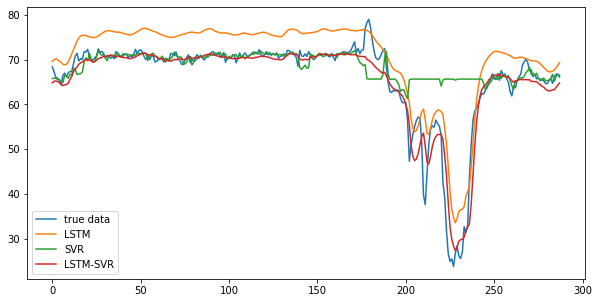

In [9]:
lstmPred   = LSTMpred[-2995:]
svrPred    = SVRpred[-2995:]
hybridPred = testPred.reshape(-1,3)
truth = testY
print('lstmPred.shape, svrPred, hybridPred, truth: ', lstmPred.shape, svrPred.shape, hybridPred.shape, truth.shape)

show_from = 0
show_to = 288
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(truth[:,0][show_from:show_to], label='true data')
ax.plot(lstmPred[:,0][show_from:show_to], label='LSTM')
ax.plot(svrPred[:,0][show_from:show_to], label='SVR')
ax.plot(hybridPred[:,0][show_from:show_to], label='LSTM-SVR')
ax.legend()